# Import modules

In [1]:
import qiskit
import pylatexenc
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import gym
from functools import reduce
from collections import deque, defaultdict

In [3]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import math, random, time, itertools
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import Parameter, ParameterVector
from tqdm.notebook import tqdm
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp, CircuitOp, AerPauliExpectation
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit.utils import QuantumInstance, algorithm_globals

In [4]:
from Curling import Curling
from ansatz import build_circuit

# Build CIrucit

### Ansatz list
- 'base'
- 'hw_eff'
- 'universal'
- 'universal_encoding'

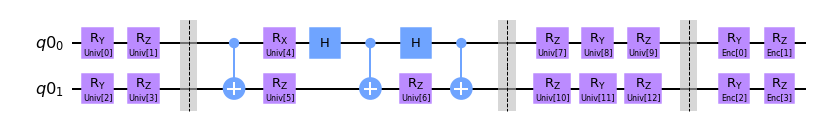

In [5]:
def draw_example():
    quantum_circuit, param_rot, param_enc = build_circuit(n_qubits=2, n_layers=1, opt='universal_encoding')
    return quantum_circuit
draw_example().draw('mpl')

In [6]:
# circuit, rot_params, enc_params = build_circuit(n_qubits=2, n_layers=1)

In [139]:
class PQC_with_DataReuploading(nn.Module):
    def __init__(self, n_qubits, n_layers, output_dim, observables=None, ansatz='base', activation='linear'):
        super().__init__()
        
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.output_dim = output_dim
        self.activation = activation
        self.ansatz = ansatz
        
        if observables == None:
            self.observables = Z^n_qubits
        else:
            self.observables = observables
        
        # Build circuits / Parameter Vectors
        self.circuit, self.rot_params, self.enc_params = build_circuit(self.n_qubits, self.n_layers, ansatz)
        self.len_rot_params = len(self.rot_params)
        self.len_enc_params = len(self.enc_params)
        
        self.psi = CircuitStateFn(primitive=self.circuit, coeff=1.)
        self.Op = ~StateFn(self.observables) @ self.psi
        
        # set method to calculcate expected values
        expval = AerPauliExpectation()
        # define gradient method
        gradient = Gradient()
        # define quantum instances (statevector and sample based)
        qi_sv = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
        # we set shots to 10 as this will determine the number of samples later on.
        qi_qasm = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1000)
        
        self.qnn = OpflowQNN(operator=self.Op, input_params=self.enc_params, weight_params=self.rot_params, 
                             exp_val=expval, gradient=gradient, quantum_instance=qi_sv, input_gradients=True)
        
        self.total_params = []
        for p in self.rot_params:
            self.total_params.append(p)
        for p in self.enc_params:
            self.total_params.append(p)
        
        # Initial Parameters for circuit
#         self.rot_param_vals = nn.Parameter(2*np.pi * torch.rand(len(self.rot_params)))
        self.rot_param_vals = nn.Parameter(2*np.pi * torch.rand(len(self.rot_params)))
#         self.enc_param_vals = nn.Parameter(torch.ones(len(self.enc_params)))
#         self.enc_param_vals  = nn.Parameter(nn.Parameter(torch.rand(len(self.enc_params))))
        self.enc_param_vals  = nn.Parameter(torch.rand(len(self.enc_params)))
        
        # Parameter for circuit output
#         self.w = nn.Parameter(nn.Parameter(torch.rand(self.output_dim)))
        self.w = nn.Parameter(torch.tensor([-1,1], dtype=torch.float32))
        
    def forward(self, inputs):
        input_tiled = self.get_input_tiled(inputs)
        input_scaled = self.enc_param_vals * input_tiled
        input_params = input_scaled
    
        expectation = self.qnn.forward(input_params.detach(), self.rot_param_vals.detach())
        
        action_exp = torch.tensor(expectation) * self.w
        action_prob = F.softmax(action_exp, dim=1)
        
        return action_prob

    def backward(self, inputs):
        input_tiled = self.get_input_tiled(inputs)
        input_scaled = self.enc_param_vals * input_tiled
        input_params = input_scaled
        expectation = self.qnn.forward(input_params.detach(), self.rot_param_vals.detach())
        enc_grad, rot_grad = self.qnn.backward(input_params.detach(), self.rot_param_vals.detach())
        w_grad = torch.tensor(expectation).tile(self.output_dim)
        return torch.tensor(rot_grad.squeeze()), torch.tensor(enc_grad.squeeze()), w_grad
    
    def get_input_tiled(self, inputs):
        # Input: State values -> Need to insert into Encoding gates with scaling parameters(encoding params)
        if self.ansatz == 'universal_encoding' or self.ansatz == 'hw_eff':
            input_tiled = inputs.tile(2)
            input_tiled = input_tiled.tile(self.n_layers)
        elif self.ansatz == 'universal':
            input_tiled = torch.zeros((inputs.shape[0], inputs.shape[1]+1))
            input_tiled[:,:2] = inputs
            input_tiled[:,-1] = inputs[:,-1]
        else:
            input_tiled = inputs.tile(self.n_layers)
        return input_tiled

In [144]:
policy = PQC_with_DataReuploading(n_qubits=2, n_layers=1, output_dim=2, observables=None, ansatz='universal_encoding')

In [145]:
policy.observables

PauliOp(Pauli('ZZ'), coeff=1.0)

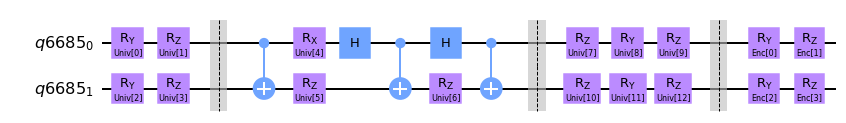

In [146]:
policy.circuit.draw('mpl')

In [147]:
inputs = torch.rand((10,2))

In [148]:
policy.rot_param_vals

Parameter containing:
tensor([2.2211, 6.0045, 6.2647, 0.7877, 0.7513, 1.3920, 0.2017, 3.0370, 3.2253,
        1.9441, 5.5892, 3.9131, 3.3748], requires_grad=True)

In [149]:
policy.enc_param_vals

Parameter containing:
tensor([0.8325, 0.7776, 0.1928, 0.1564], requires_grad=True)

In [150]:
policy.w

Parameter containing:
tensor([-1.,  1.], requires_grad=True)

In [151]:
policy.forward(inputs)

tensor([[0.5393, 0.4607],
        [0.5346, 0.4654],
        [0.5270, 0.4730],
        [0.5342, 0.4658],
        [0.5365, 0.4635],
        [0.5159, 0.4841],
        [0.5393, 0.4607],
        [0.5099, 0.4901],
        [0.5391, 0.4609],
        [0.5327, 0.4673]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)

In [152]:
policy.forward(inputs)

tensor([[0.5393, 0.4607],
        [0.5346, 0.4654],
        [0.5270, 0.4730],
        [0.5342, 0.4658],
        [0.5365, 0.4635],
        [0.5159, 0.4841],
        [0.5393, 0.4607],
        [0.5099, 0.4901],
        [0.5391, 0.4609],
        [0.5327, 0.4673]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)

In [153]:
policy.forward(inputs)

tensor([[0.5393, 0.4607],
        [0.5346, 0.4654],
        [0.5270, 0.4730],
        [0.5342, 0.4658],
        [0.5365, 0.4635],
        [0.5159, 0.4841],
        [0.5393, 0.4607],
        [0.5099, 0.4901],
        [0.5391, 0.4609],
        [0.5327, 0.4673]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)

In [154]:
s = time.time()
a,b,c = policy.backward(inputs)
print(time.time()-s)

1.5223793983459473


# Make Quantum Agent

In [155]:
class QuantumAgent():
    def __init__(self, input_state_dim, n_actions, n_layers=1, ansatz='base'):
        self.policy = PQC_with_DataReuploading(n_qubits=input_state_dim, n_layers=n_layers, 
                                               output_dim=n_actions, observables=None, ansatz=ansatz,
                                               activation='linear')
        self.n_layers = n_layers
        self.variational_optim = torch.optim.Adam([self.policy.rot_param_vals], lr=0.1)
        self.encoding_optim = torch.optim.Adam([self.policy.enc_param_vals], lr=0.1)
        self.weight_optim = torch.optim.Adam([self.policy.w], lr=0.01)
        
        self.lr = 1
        
        self.optims = [self.variational_optim, self.encoding_optim, self.weight_optim]
        
    def get_actions(self, input_state):
        return self.policy.forward(input_state)
    
    def update_policy(self, states, id_action_pairs, returns, action_probs, batch_size):
        r_grad, e_grad, w_grad = self.policy.backward(states)
        
        p_actions = torch.tensor([action_probs[id_action_pairs[i][0], id_action_pairs[i][1]] for i in range(action_probs.shape[0])])
        p_actions = p_actions.reshape(p_actions.shape[0], -1)
        action_idxs = id_action_pairs[:,1]
        
        returns = returns.reshape(returns.shape[0], -1)
        action_weights = agent.policy.w.detach().numpy()[id_action_pairs[:,1]]
        action_weights = action_weights[:,np.newaxis]
        
        w = agent.policy.w.tile(len(states)).reshape(len(states),-1)
        
        rot_grad = returns * ( r_grad * torch.tensor(action_weights) - torch.sum(p_actions * w) * r_grad)
        input_scaled = self.policy.enc_param_vals * self.policy.get_input_tiled(states)
        
        enc_grad = returns * ( e_grad * torch.tensor(action_weights) - input_scaled * torch.sum(p_actions * w) * e_grad)
        weight_grad = returns * ( w_grad * torch.tensor(action_weights) - torch.sum(p_actions * w) * w_grad)
        
        prev = self.policy.rot_param_vals.detach().numpy().copy()
        prev1 = self.policy.enc_param_vals.detach().numpy().copy()
        prev2 = self.policy.w.detach().numpy().copy()
        
        rot_update = (torch.mean(rot_grad.detach(), dim=0) / batch_size).type(torch.float32)
        enc_update = (torch.mean(enc_grad, dim=0).detach() / batch_size).type(torch.float32)
        w_update = (torch.mean(weight_grad, dim=0).detach() / batch_size).type(torch.float32)
#         rot_update = torch.mean(rot_grad, dim=0) / batch_size
#         enc_update = torch.mean(enc_grad, dim=0) / batch_size
        
#         self.policy.rot_param_vals += self.lr * rot_update
#         self.policy.enc_param_vals += self.lr * enc_update

#         with torch.no_grad():
    
        self.policy.rot_param_vals.grad = -1*rot_update
        self.policy.enc_param_vals.grad = -1*enc_update
        self.policy.w.grad = -1*w_update
                
#         print(rot_update)
#         print(enc_update)
        
        self.variational_optim.step()
        self.encoding_optim.step()
        self.weight_optim.step()

        print(self.policy.rot_param_vals.detach() - prev)
        print(rot_update)
        print(self.policy.enc_param_vals.detach() - prev1)
        print(enc_update)
        print(self.policy.w.detach() - prev2)
        print(w_update)
        
#         with torch.no_grad():
#             self.policy.rot_param_vals[self.policy.rot_param_vals > 2*np.pi] = 2*np.pi
#             self.policy.enc_param_vals[self.policy.enc_param_vals > 2*np.pi] = 2*np.pi
#             self.policy.rot_param_vals[self.policy.rot_param_vals < 0] = 0
#             self.policy.enc_param_vals[self.policy.enc_param_vals < 0] = 0
        
#         print(self.policy.rot_param_vals)

In [172]:
n_qubits = 2 # Dimension of the state vectors in CartPole
n_layers = 1
n_actions = 2 # Number of actions in CartPole
agent = QuantumAgent(input_state_dim = n_qubits, n_actions=n_actions, n_layers=n_layers, ansatz='universal_encoding')

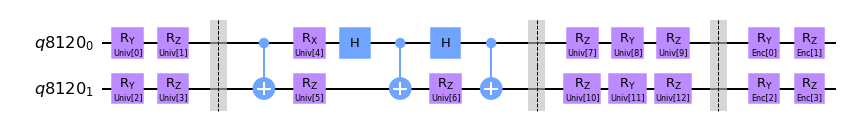

In [173]:
agent.policy.circuit.draw('mpl')

# Run Episodes and Update Policy

In [174]:
def gather_episodes(state_bounds, n_actions, agent, n_episodes, env_name):
    """Interact with environment in batched fashion."""

    trajectories = [defaultdict(list) for _ in range(n_episodes)]
    if env_name == 'Curling':
        envs = [Curling(reward_type='each_end_counts') for _ in range(n_episodes)]
    else:
        envs = [gym.make(env_name) for _ in range(n_episodes)]

    done = [False for _ in range(n_episodes)]
    states = [e.reset() for e in envs]

    while not all(done):
        unfinished_ids = [i for i in range(n_episodes) if not done[i]]
        normalized_states = [s/state_bounds for i, s in enumerate(states) if not done[i]]

        for i, state in zip(unfinished_ids, normalized_states):
            trajectories[i]['states'].append(state)

        states = torch.from_numpy(np.array(normalized_states))
        action_probs = agent.get_actions(states)

        # Store action and transition all environments to the next state
        states = [None for i in range(n_episodes)]
        for i, action_prob in zip(unfinished_ids, action_probs.detach().numpy()):
            action = np.random.choice(n_actions, p=action_prob)
            states[i], reward, done[i], _ = envs[i].step(action)
            trajectories[i]['actions'].append(action)
            trajectories[i]['rewards'].append(reward)
            trajectories[i]['action probs'].append(action_prob)

    return trajectories

def compute_returns(rewards_history, gamma):
    """Compute discounted returns with discount factor `gamma`."""
    returns = []
    discounted_sum = 0
    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    # Normalize them for faster and more stable learning
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()

    return returns

In [175]:
env_name = "Curling"
# env_name = "Curling"
if env_name == "CartPole-v1":
    state_bounds = np.array([2.4, 2.5, 0.21, 2.5])
elif env_name == 'Curling':
    state_bounds = np.array([3, 1])
gamma = 1
batch_size = 10
n_episodes = 1000

In [ ]:
# Start training the agent
episode_reward_history = []
# Monitoring reward
monitor_reward_history = []
for batch in tqdm(range(n_episodes // batch_size)):
    # Gather episodes
    episodes = gather_episodes(state_bounds, n_actions, agent, batch_size, env_name)

    # Group states, actions and returns in numpy arrays
    states = torch.from_numpy(np.concatenate([ep['states'] for ep in episodes]))
    actions = torch.from_numpy(np.concatenate([ep['actions'] for ep in episodes]))
    action_probs = torch.from_numpy(np.concatenate([ep['action probs'] for ep in episodes]))
    rewards = [ep['rewards'] for ep in episodes]
    returns = np.concatenate([compute_returns(ep_rwds, gamma) for ep_rwds in rewards])
    returns = torch.from_numpy(np.array(returns))

    id_action_pairs = torch.from_numpy(np.array([[i, a] for i, a in enumerate(actions)]))

    # Update model parameters.
    agent.update_policy(states, id_action_pairs, returns, action_probs, batch_size)
    print(action_probs)

    if batch % 5 == 1:
        # Gather episodes
        episodes = gather_episodes(state_bounds, n_actions, agent, 50, env_name)

        # Group states, actions and returns in numpy arrays
        states = torch.from_numpy(np.concatenate([ep['states'] for ep in episodes]))
        actions = torch.from_numpy(np.concatenate([ep['actions'] for ep in episodes]))
        action_probs = torch.from_numpy(np.concatenate([ep['action probs'] for ep in episodes]))
        rewards = [ep['rewards'] for ep in episodes]
        # Store collected rewards
        temp_hist = []
        for ep_rwds in rewards:
            temp_hist.append(np.sum(ep_rwds))
        avg_rewards = np.mean(temp_hist)
        monitor_reward_history.append(avg_rewards)
        
        print('Monitored episode', 50,
              'Average Monitored rewards: ', avg_rewards)

    # Store collected rewards
    for ep_rwds in rewards:
        episode_reward_history.append(np.sum(ep_rwds))

    avg_rewards = np.mean(episode_reward_history[-batch_size:])

    print('Finished episode', (batch + 1) * batch_size,
          'Average rewards: ', avg_rewards)

    if avg_rewards >= 500.0:
        break

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([ 0.1000,  0.1000, -0.1000, -0.1000, -0.1000,  0.1000, -0.1000,  0.1000,
        -0.1000,  0.1000, -0.1000, -0.1000,  0.1000])
tensor([ 1.3646e-03,  3.6037e-03, -4.5166e-03, -1.1810e-03, -4.4549e-03,
         8.5079e-04, -9.3082e-04,  1.8874e-03, -9.5028e-04,  9.3541e-04,
        -9.3504e-04, -1.5370e-03,  9.7127e-05])
tensor([0.1000, 0.0000, 0.1000, 0.0000])
tensor([ 2.5870e-03, -1.4116e-19,  2.2881e-03,  4.4798e-20])
tensor([0.0100, 0.0100])
tensor([0.0043, 0.0043])
tensor([[0.4072, 0.5928],
        [0.2460, 0.7540],
        [0.2460, 0.7540],
        [0.2695, 0.7305],
        [0.6731, 0.3269],
        [0.7841, 0.2159],
        [0.7841, 0.2159],
        [0.7627, 0.2373],
        [0.5213, 0.4787],
        [0.3656, 0.6344],
        [0.4072, 0.5928],
        [0.2460, 0.7540],
        [0.2460, 0.7540],
        [0.3656, 0.6344],
        [0.3656, 0.6344],
        [0.3656, 0.6344],
        [0.2695, 0.7305],
        [0.5213, 0.4787],
        [0.7627, 0.2373],
        [0.7415, 0.2585],


tensor([-0.0338,  0.0529, -0.0833,  0.0719, -0.0924,  0.0360,  0.0453,  0.0634,
        -0.0757,  0.0005, -0.0793, -0.0647,  0.0779])
tensor([-0.0304,  0.0212, -0.0195,  0.0664, -0.0062, -0.0026,  0.0429,  0.0820,
        -0.0353, -0.0017, -0.0340, -0.0347,  0.0266])
tensor([-0.0193,  0.0000,  0.0868,  0.0000])
tensor([ 9.8565e-03, -9.3316e-19,  4.5204e-02, -1.2299e-19])
tensor([0.0075, 0.0075])
tensor([0.0722, 0.0722])
tensor([[0.6505, 0.3495],
        [0.6505, 0.3495],
        [0.7400, 0.2600],
        [0.7400, 0.2600],
        [0.7183, 0.2817],
        [0.5753, 0.4247],
        [0.3492, 0.6508],
        [0.1250, 0.8750],
        [0.3492, 0.6508],
        [0.5753, 0.4247],
        [0.6505, 0.3495],
        [0.7400, 0.2600],
        [0.7183, 0.2817],
        [0.5753, 0.4247],
        [0.3492, 0.6508],
        [0.5753, 0.4247],
        [0.5753, 0.4247],
        [0.7183, 0.2817],
        [0.7183, 0.2817],
        [0.7400, 0.2600],
        [0.6505, 0.3495],
        [0.7400, 0.2600],
    

tensor([ 0.0710, -0.0454,  0.0659,  0.0610,  0.0706,  0.0726, -0.0672, -0.0440,
        -0.0828, -0.0771, -0.0744, -0.0832,  0.0674])
tensor([ 0.0873, -0.0168,  0.0708, -0.0157,  0.0479,  0.0330, -0.1078, -0.1209,
        -0.0064, -0.0309,  0.0046, -0.0274, -0.0096])
tensor([0.0677, 0.0000, 0.0434, 0.0000])
tensor([ 4.1979e-02, -9.6992e-19, -1.0279e-01,  4.8174e-19])
tensor([0.0088, 0.0088])
tensor([0.1315, 0.1315])
tensor([[0.6652, 0.3348],
        [0.6273, 0.3727],
        [0.6652, 0.3348],
        [0.6273, 0.3727],
        [0.5341, 0.4659],
        [0.5341, 0.4659],
        [0.4686, 0.5314],
        [0.7775, 0.2225],
        [0.8594, 0.1406],
        [0.8594, 0.1406],
        [0.6652, 0.3348],
        [0.6652, 0.3348],
        [0.6652, 0.3348],
        [0.6012, 0.3988],
        [0.6012, 0.3988],
        [0.6012, 0.3988],
        [0.4291, 0.5709],
        [0.2431, 0.7569],
        [0.2431, 0.7569],
        [0.1285, 0.8715],
        [0.6652, 0.3348],
        [0.2431, 0.7569],
        

tensor([ 0.0666, -0.0633,  0.0762, -0.0024,  0.0885,  0.0872, -0.0649, -0.0179,
        -0.0716, -0.0711, -0.0658,  0.0281,  0.0514])
tensor([ 0.0048, -0.0027,  0.0196, -0.0616,  0.0548,  0.1104, -0.0137,  0.0345,
         0.0102,  0.0097,  0.0110,  0.0590, -0.0152])
tensor([0.0334, 0.0000, 0.0185, 0.0000])
tensor([-9.4555e-02, -2.2421e-18,  1.5065e-01,  6.3863e-19])
tensor([0.0093, 0.0093])
tensor([0.2910, 0.2910])
tensor([[0.3759, 0.6241],
        [0.4257, 0.5743],
        [0.4257, 0.5743],
        [0.5741, 0.4259],
        [0.4257, 0.5743],
        [0.6768, 0.3232],
        [0.7655, 0.2345],
        [0.8203, 0.1797],
        [0.8203, 0.1797],
        [0.8426, 0.1574],
        [0.3759, 0.6241],
        [0.3192, 0.6808],
        [0.1901, 0.8099],
        [0.1330, 0.8670],
        [0.1652, 0.8348],
        [0.1401, 0.8599],
        [0.1488, 0.8512],
        [0.2523, 0.7477],
        [0.1330, 0.8670],
        [0.1652, 0.8348],
        [0.3759, 0.6241],
        [0.4257, 0.5743],
        

Monitored episode 50 Average Monitored rewards:  40.6
Finished episode 120 Average rewards:  38.2
tensor([ 0.0118,  0.0124,  0.0358, -0.0589,  0.0876,  0.0925, -0.0132,  0.0340,
         0.0353,  0.0398,  0.0428,  0.0376, -0.0468])
tensor([ 0.0092,  0.0824,  0.0051, -0.1470,  0.0235,  0.0504,  0.0078,  0.0495,
         0.1711,  0.0839,  0.1539, -0.0218, -0.1446])
tensor([-0.0395,  0.0000,  0.0502,  0.0000])
tensor([-3.2595e-01,  1.7959e-18,  5.4339e-01,  2.5593e-18])
tensor([0.0101, 0.0101])
tensor([0.3534, 0.3534])
tensor([[0.4208, 0.5792],
        [0.5588, 0.4412],
        [0.6336, 0.3664],
        [0.6336, 0.3664],
        [0.6336, 0.3664],
        [0.5588, 0.4412],
        [0.4208, 0.5792],
        [0.4208, 0.5792],
        [0.3415, 0.6585],
        [0.4208, 0.5792],
        [0.4208, 0.5792],
        [0.3415, 0.6585],
        [0.2617, 0.7383],
        [0.1979, 0.8021],
        [0.1425, 0.8575],
        [0.1468, 0.8532],
        [0.1588, 0.8412],
        [0.1982, 0.8018],
        [0

tensor([-0.0156,  0.0378,  0.0192, -0.0283,  0.0615,  0.0256,  0.0112,  0.0380,
         0.0332,  0.0677,  0.0404,  0.0260, -0.0424])
tensor([-0.0208, -0.0138, -0.0377,  0.0891,  0.0225, -0.0928, -0.0074,  0.1241,
        -0.0582,  0.0442, -0.0272,  0.1212,  0.0278])
tensor([ 0.0247,  0.0000, -0.0241,  0.0000])
tensor([ 7.6488e-01, -1.0715e-17, -1.4677e+00,  2.6672e-18])
tensor([0.0105, 0.0105])
tensor([0.4438, 0.4438])
tensor([[0.4511, 0.5489],
        [0.2325, 0.7675],
        [0.1377, 0.8623],
        [0.1702, 0.8298],
        [0.3290, 0.6710],
        [0.2325, 0.7675],
        [0.1377, 0.8623],
        [0.1364, 0.8636],
        [0.1626, 0.8374],
        [0.2811, 0.7189],
        [0.4511, 0.5489],
        [0.6870, 0.3130],
        [0.8609, 0.1391],
        [0.8609, 0.1391],
        [0.8738, 0.1262],
        [0.8674, 0.1326],
        [0.8393, 0.1607],
        [0.8674, 0.1326],
        [0.8738, 0.1262],
        [0.8738, 0.1262],
        [0.4511, 0.5489],
        [0.6870, 0.3130],
    

tensor([-0.0182,  0.0041, -0.0057,  0.0444, -0.0190, -0.0445,  0.0217,  0.0015,
        -0.0277,  0.0198, -0.0250,  0.0092,  0.0270])
tensor([ 0.0220,  0.0046, -0.0745,  0.2185, -0.1635, -0.1465,  0.0147, -0.1013,
        -0.1735, -0.0188, -0.1640, -0.0695,  0.1664])
tensor([ 0.0196,  0.0000, -0.0223,  0.0000])
tensor([-3.6890e-01, -1.0089e-17,  5.2916e-01,  1.9260e-18])
tensor([0.0111, 0.0111])
tensor([0.6252, 0.6252])
tensor([[0.4631, 0.5369],
        [0.4631, 0.5369],
        [0.2881, 0.7119],
        [0.2881, 0.7119],
        [0.2068, 0.7932],
        [0.3827, 0.6173],
        [0.5239, 0.4761],
        [0.4631, 0.5369],
        [0.3827, 0.6173],
        [0.2881, 0.7119],
        [0.4631, 0.5369],
        [0.4631, 0.5369],
        [0.3827, 0.6173],
        [0.3827, 0.6173],
        [0.3827, 0.6173],
        [0.2068, 0.7932],
        [0.2881, 0.7119],
        [0.4631, 0.5369],
        [0.5239, 0.4761],
        [0.5836, 0.4164],
        [0.4631, 0.5369],
        [0.5239, 0.4761],
    

tensor([ 0.0047, -0.0179, -0.0164,  0.0487, -0.0545, -0.0610,  0.0101, -0.0175,
        -0.0281, -0.0308, -0.0273, -0.0028,  0.0305])
tensor([ 0.0412,  0.0651,  0.0645, -0.0324, -0.0668, -0.0467,  0.0209, -0.2627,
         0.0700, -0.0593,  0.0313, -0.2570, -0.0276])
tensor([-0.0082,  0.0000,  0.0048,  0.0000])
tensor([-3.0736e-01, -1.5048e-18,  4.9205e-01,  5.6108e-18])
tensor([0.0116, 0.0116])
tensor([0.8103, 0.8103])
tensor([[0.4757, 0.5243],
        [0.6600, 0.3400],
        [0.7357, 0.2643],
        [0.7914, 0.2086],
        [0.8518, 0.1482],
        [0.8659, 0.1341],
        [0.8744, 0.1256],
        [0.8677, 0.1323],
        [0.8744, 0.1256],
        [0.8733, 0.1267],
        [0.4757, 0.5243],
        [0.4757, 0.5243],
        [0.6600, 0.3400],
        [0.7357, 0.2643],
        [0.7914, 0.2086],
        [0.8518, 0.1482],
        [0.8659, 0.1341],
        [0.8733, 0.1267],
        [0.8733, 0.1267],
        [0.8744, 0.1256],
        [0.4757, 0.5243],
        [0.5696, 0.4304],
    

tensor([-0.0014, -0.0504, -0.0447,  0.0011, -0.0485, -0.0160, -0.0065,  0.0178,
        -0.0016, -0.0322,  0.0176,  0.0302, -0.0149])
tensor([ 0.0050, -0.0853, -0.0230, -0.1788, -0.0143,  0.1156, -0.0175,  0.0074,
         0.1185, -0.0916,  0.1349,  0.0313, -0.1269])
tensor([-0.0337,  0.0000,  0.0296,  0.0000])
tensor([-5.1749e-02, -3.9083e-18,  7.7559e-02,  1.0592e-17])
tensor([0.0121, 0.0121])
tensor([0.8841, 0.8841])
tensor([[0.5429, 0.4571],
        [0.4417, 0.5583],
        [0.2574, 0.7426],
        [0.3434, 0.6566],
        [0.4417, 0.5583],
        [0.4417, 0.5583],
        [0.2574, 0.7426],
        [0.3434, 0.6566],
        [0.4417, 0.5583],
        [0.6399, 0.3601],
        [0.5429, 0.4571],
        [0.5429, 0.4571],
        [0.7261, 0.2739],
        [0.7944, 0.2056],
        [0.8743, 0.1257],
        [0.8682, 0.1318],
        [0.8743, 0.1257],
        [0.8663, 0.1337],
        [0.8408, 0.1592],
        [0.7944, 0.2056],
        [0.7261, 0.2739],
        [0.5429, 0.4571],
    

Monitored episode 50 Average Monitored rewards:  43.94
Finished episode 270 Average rewards:  38.6
tensor([ 0.0027, -0.0188, -0.0147, -0.0388,  0.0127,  0.0384, -0.0131,  0.0201,
         0.0275, -0.0019,  0.0487,  0.0216, -0.0492])
tensor([-0.0945, -0.1555, -0.1509,  0.0054,  0.0866,  0.1176,  0.0327,  0.3989,
        -0.0792,  0.0374,  0.0217,  0.4312, -0.0289])
tensor([ 0.0352,  0.0000, -0.0385,  0.0000])
tensor([ 1.7013e+00, -1.2756e-18, -3.1096e+00,  3.6157e-18])
tensor([0.0124, 0.0124])
tensor([0.7975, 0.7975])
tensor([[0.5800, 0.4200],
        [0.5800, 0.4200],
        [0.3335, 0.6665],
        [0.1757, 0.8243],
        [0.1399, 0.8601],
        [0.1394, 0.8606],
        [0.1394, 0.8606],
        [0.2256, 0.7744],
        [0.4229, 0.5771],
        [0.3092, 0.6908],
        [0.5800, 0.4200],
        [0.5800, 0.4200],
        [0.5800, 0.4200],
        [0.6906, 0.3094],
        [0.7740, 0.2260],
        [0.7740, 0.2260],
        [0.6906, 0.3094],
        [0.5800, 0.4200],
        [

tensor([-0.0161, -0.0044, -0.0009,  0.0047,  0.0343,  0.0318,  0.0076,  0.0139,
        -0.0219,  0.0108, -0.0133,  0.0158,  0.0110])
tensor([-0.0205, -0.0371,  0.0353,  0.1737,  0.0494, -0.0133,  0.0103, -0.0236,
        -0.1886, -0.0438, -0.1862,  0.0484,  0.1868])
tensor([ 0.0167,  0.0000, -0.0237,  0.0000])
tensor([-1.5537e+00, -1.7259e-17,  2.1923e+00,  1.1921e-17])
tensor([0.0126, 0.0126])
tensor([1.1263, 1.1263])
tensor([[0.5897, 0.4103],
        [0.5256, 0.4744],
        [0.6525, 0.3475],
        [0.7152, 0.2848],
        [0.7723, 0.2277],
        [0.8166, 0.1834],
        [0.8166, 0.1834],
        [0.8600, 0.1400],
        [0.8600, 0.1400],
        [0.8451, 0.1549],
        [0.5897, 0.4103],
        [0.5256, 0.4744],
        [0.5256, 0.4744],
        [0.5897, 0.4103],
        [0.6525, 0.3475],
        [0.7152, 0.2848],
        [0.7723, 0.2277],
        [0.7152, 0.2848],
        [0.6525, 0.3475],
        [0.5897, 0.4103],
        [0.5897, 0.4103],
        [0.5256, 0.4744],
    

tensor([ 0.0204,  0.0396,  0.0477,  0.0168,  0.0246, -0.0009, -0.0014, -0.0389,
        -0.0170,  0.0063, -0.0426, -0.0365,  0.0445])
tensor([ 0.1139,  0.3685,  0.3636, -0.0716, -0.0216, -0.1006,  0.0047, -0.7095,
         0.1610,  0.0294, -0.0275, -0.8249,  0.0409])
tensor([-0.0288,  0.0000,  0.0188,  0.0000])
tensor([-3.6088e-02, -1.3922e-18,  6.2526e-02,  4.6202e-18])
tensor([0.0130, 0.0130])
tensor([1.3361, 1.3361])
tensor([[0.6075, 0.3925],
        [0.5271, 0.4729],
        [0.3659, 0.6341],
        [0.1978, 0.8022],
        [0.1978, 0.8022],
        [0.2411, 0.7589],
        [0.1978, 0.8022],
        [0.1293, 0.8707],
        [0.1293, 0.8707],
        [0.1436, 0.8564],
        [0.6075, 0.3925],
        [0.5271, 0.4729],
        [0.4444, 0.5556],
        [0.5271, 0.4729],
        [0.6075, 0.3925],
        [0.6075, 0.3925],
        [0.6798, 0.3202],
        [0.7403, 0.2597],
        [0.7882, 0.2118],
        [0.8241, 0.1759],
        [0.6075, 0.3925],
        [0.6798, 0.3202],
    

tensor([ 0.0080,  0.0408,  0.0289, -0.0030, -0.0214, -0.0235,  0.0223, -0.0364,
         0.0169,  0.0070, -0.0014, -0.0374,  0.0022])
tensor([-0.0317,  0.0280, -0.0484, -0.0628, -0.0827, -0.0474,  0.0544, -0.0184,
         0.1005,  0.0070,  0.0907, -0.0389, -0.0914])
tensor([-0.0142,  0.0000,  0.0054,  0.0000])
tensor([ 1.9156e+00, -6.4317e-18, -3.3375e+00, -5.0231e-18])
tensor([0.0133, 0.0133])
tensor([1.2634, 1.2634])
tensor([[0.4508, 0.5492],
        [0.7486, 0.2514],
        [0.7486, 0.2514],
        [0.6616, 0.3384],
        [0.6616, 0.3384],
        [0.6616, 0.3384],
        [0.6616, 0.3384],
        [0.5582, 0.4418],
        [0.6616, 0.3384],
        [0.7486, 0.2514],
        [0.4508, 0.5492],
        [0.4508, 0.5492],
        [0.5582, 0.4418],
        [0.8118, 0.1882],
        [0.8513, 0.1487],
        [0.8772, 0.1228],
        [0.8711, 0.1289],
        [0.8542, 0.1458],
        [0.8252, 0.1748],
        [0.8252, 0.1748],
        [0.4508, 0.5492],
        [0.4508, 0.5492],
    

tensor([-0.0114, -0.0075, -0.0231, -0.0165, -0.0391, -0.0189,  0.0056,  0.0083,
         0.0165, -0.0044,  0.0257,  0.0082, -0.0254])
tensor([ 0.0215,  0.0495,  0.0347, -0.0680, -0.0218,  0.0157,  0.0042, -0.0994,
         0.0819, -0.0104,  0.0598, -0.1198, -0.0597])
tensor([-0.0031,  0.0000, -0.0037,  0.0000])
tensor([-1.3158e+00, -2.6898e-18,  2.2119e+00,  2.6227e-18])
tensor([0.0136, 0.0136])
tensor([1.3777, 1.3777])
tensor([[0.4178, 0.5822],
        [0.3220, 0.6780],
        [0.4178, 0.5822],
        [0.5250, 0.4750],
        [0.5250, 0.4750],
        [0.4178, 0.5822],
        [0.2458, 0.7542],
        [0.3220, 0.6780],
        [0.4178, 0.5822],
        [0.5250, 0.4750],
        [0.4178, 0.5822],
        [0.3220, 0.6780],
        [0.4178, 0.5822],
        [0.4178, 0.5822],
        [0.6300, 0.3700],
        [0.6300, 0.3700],
        [0.5250, 0.4750],
        [0.4178, 0.5822],
        [0.4178, 0.5822],
        [0.3220, 0.6780],
        [0.4178, 0.5822],
        [0.4178, 0.5822],
    

Monitored episode 50 Average Monitored rewards:  41.36
Finished episode 420 Average rewards:  26.8
tensor([-0.0129, -0.0160, -0.0193,  0.0009, -0.0033, -0.0002, -0.0030,  0.0180,
        -0.0119, -0.0019, -0.0008,  0.0190,  0.0010])
tensor([-0.1016, -0.0527, -0.0744,  0.1310,  0.0759,  0.0243,  0.0543,  0.2704,
        -0.1739,  0.0715, -0.1238,  0.2700,  0.1191])
tensor([-0.0044,  0.0000, -0.0004,  0.0000])
tensor([-5.5364e-01, -1.1292e-17,  9.8467e-01,  3.4441e-17])
tensor([0.0140, 0.0140])
tensor([1.9639, 1.9639])
tensor([[0.4592, 0.5408],
        [0.4592, 0.5408],
        [0.5688, 0.4312],
        [0.5688, 0.4312],
        [0.8113, 0.1887],
        [0.8715, 0.1285],
        [0.8715, 0.1285],
        [0.8797, 0.1203],
        [0.8764, 0.1236],
        [0.8340, 0.1660],
        [0.4592, 0.5408],
        [0.2673, 0.7327],
        [0.2673, 0.7327],
        [0.2021, 0.7979],
        [0.1585, 0.8415],
        [0.2673, 0.7327],
        [0.2673, 0.7327],
        [0.4592, 0.5408],
        [

tensor([-0.0290, -0.0449, -0.0329,  0.0194,  0.0332,  0.0184, -0.0087,  0.0470,
        -0.0415,  0.0005, -0.0155,  0.0495,  0.0143])
tensor([-0.0570, -0.1690, -0.1537,  0.0429,  0.0337,  0.0263,  0.0027,  0.3740,
        -0.0794,  0.0237,  0.0099,  0.4160, -0.0169])
tensor([ 0.0099,  0.0000, -0.0141,  0.0000])
tensor([ 8.6156e-01, -1.9494e-18, -1.5122e+00,  1.6251e-17])
tensor([0.0143, 0.0143])
tensor([1.7545, 1.7545])
tensor([[0.5603, 0.4397],
        [0.4435, 0.5565],
        [0.5603, 0.4397],
        [0.7523, 0.2477],
        [0.6673, 0.3327],
        [0.4435, 0.5565],
        [0.4435, 0.5565],
        [0.2477, 0.7523],
        [0.3347, 0.6653],
        [0.2477, 0.7523],
        [0.5603, 0.4397],
        [0.3347, 0.6653],
        [0.1483, 0.8517],
        [0.1483, 0.8517],
        [0.1247, 0.8753],
        [0.1742, 0.8258],
        [0.2271, 0.7729],
        [0.5256, 0.4744],
        [0.4082, 0.5918],
        [0.3052, 0.6948],
        [0.5603, 0.4397],
        [0.4435, 0.5565],
    

tensor([ 0.0312,  0.0447,  0.0434, -0.0371,  0.0298,  0.0078, -0.0135, -0.0350,
         0.0335,  0.0089,  0.0158, -0.0388, -0.0150])
tensor([ 0.0468,  0.4120,  0.3557, -0.2074, -0.0648, -0.0383,  0.0785, -0.7969,
         0.2731, -0.0274,  0.0793, -0.9403, -0.0627])
tensor([ 0.0156,  0.0000, -0.0188,  0.0000])
tensor([-3.3231e-01, -1.5515e-17,  5.5525e-01,  7.8964e-18])
tensor([0.0146, 0.0146])
tensor([2.1822, 2.1822])
tensor([[0.6107, 0.3893],
        [0.7696, 0.2304],
        [0.7696, 0.2304],
        [0.8193, 0.1807],
        [0.8521, 0.1479],
        [0.8521, 0.1479],
        [0.8714, 0.1286],
        [0.8799, 0.1201],
        [0.8799, 0.1201],
        [0.8799, 0.1201],
        [0.6107, 0.3893],
        [0.8193, 0.1807],
        [0.7696, 0.2304],
        [0.7000, 0.3000],
        [0.7000, 0.3000],
        [0.5079, 0.4921],
        [0.6107, 0.3893],
        [0.5079, 0.4921],
        [0.6107, 0.3893],
        [0.8193, 0.1807],
        [0.6107, 0.3893],
        [0.7000, 0.3000],
    

tensor([ 0.0018,  0.0533,  0.0446, -0.0104, -0.0339, -0.0288,  0.0509, -0.0581,
         0.0245, -0.0071, -0.0131, -0.0567,  0.0164])
tensor([ 0.0720,  0.3506,  0.3006,  0.0427, -0.1648, -0.0769,  0.1217, -0.8603,
         0.0878,  0.0412, -0.0937, -0.9417,  0.1015])
tensor([-0.0212,  0.0000,  0.0181,  0.0000])
tensor([-1.1777e+00,  1.5540e-17,  1.9108e+00,  1.7492e-17])
tensor([0.0149, 0.0149])
tensor([2.6483, 2.6483])
tensor([[0.4326, 0.5674],
        [0.2070, 0.7930],
        [0.1381, 0.8619],
        [0.1644, 0.8356],
        [0.3443, 0.6557],
        [0.2675, 0.7325],
        [0.4326, 0.5674],
        [0.2675, 0.7325],
        [0.2070, 0.7930],
        [0.1644, 0.8356],
        [0.4326, 0.5674],
        [0.2675, 0.7325],
        [0.3443, 0.6557],
        [0.1644, 0.8356],
        [0.3443, 0.6557],
        [0.3443, 0.6557],
        [0.2675, 0.7325],
        [0.4326, 0.5674],
        [0.6184, 0.3816],
        [0.6184, 0.3816],
        [0.4326, 0.5674],
        [0.4326, 0.5674],
    

tensor([ 0.0462,  0.0473,  0.0409,  0.0116, -0.0650, -0.0386,  0.0220, -0.0678,
         0.0098, -0.0309, -0.0319, -0.0624,  0.0314])
tensor([ 0.1693,  0.0223,  0.0678,  0.0116, -0.0453,  0.0142, -0.0930, -0.2247,
        -0.0105, -0.0524, -0.0189, -0.2053,  0.0018])
tensor([-0.0290,  0.0000,  0.0258,  0.0000])
tensor([ 7.5076e-01,  1.6209e-17, -1.4314e+00,  2.3441e-17])
tensor([0.0153, 0.0153])
tensor([2.9510, 2.9510])
tensor([[0.2312, 0.7688],
        [0.1712, 0.8288],
        [0.1233, 0.8767],
        [0.1377, 0.8623],
        [0.1233, 0.8767],
        [0.2312, 0.7688],
        [0.1712, 0.8288],
        [0.1377, 0.8623],
        [0.1241, 0.8759],
        [0.1750, 0.8250],
        [0.2312, 0.7688],
        [0.2312, 0.7688],
        [0.3244, 0.6756],
        [0.3244, 0.6756],
        [0.3244, 0.6756],
        [0.5819, 0.4181],
        [0.7827, 0.2173],
        [0.8360, 0.1640],
        [0.8777, 0.1223],
        [0.8749, 0.1251],
        [0.2312, 0.7688],
        [0.4481, 0.5519],
    

Monitored episode 50 Average Monitored rewards:  47.64
Finished episode 570 Average rewards:  72.7
tensor([-0.0695, -0.0393, -0.0778, -0.0505, -0.0669,  0.0046, -0.0124,  0.0588,
        -0.0258, -0.0146,  0.0113,  0.0582,  0.0139])
tensor([-0.4177, -0.6173, -1.1750, -0.3961, -0.1012,  0.1979, -0.1399,  2.0805,
        -0.1681, -0.0424,  0.1533,  2.2551, -0.0672])
tensor([-0.0012,  0.0000, -0.0066,  0.0000])
tensor([ 3.7366e-02, -1.2098e-17, -1.1907e-01,  1.5118e-17])
tensor([0.0142, 0.0142])
tensor([2.1485, 2.1485])
tensor([[0.2003, 0.7997],
        [0.1488, 0.8512],
        [0.1488, 0.8512],
        [0.1218, 0.8782],
        [0.1218, 0.8782],
        [0.1394, 0.8606],
        [0.1247, 0.8753],
        [0.1394, 0.8606],
        [0.1247, 0.8753],
        [0.1394, 0.8606],
        [0.2003, 0.7997],
        [0.2003, 0.7997],
        [0.4125, 0.5875],
        [0.6880, 0.3120],
        [0.7840, 0.2160],
        [0.8720, 0.1280],
        [0.7840, 0.2160],
        [0.5567, 0.4433],
        [

tensor([-0.0566, -0.0634, -0.0734, -0.0518,  0.0351, -0.0065, -0.0434,  0.0891,
        -0.0392, -0.0229,  0.0122,  0.0870,  0.0150])
tensor([ 0.4170,  0.0105,  0.3918,  0.0998,  0.5659, -0.0958, -0.4805,  0.2669,
        -0.1445, -0.0059, -0.1642,  0.2378,  0.1628])
tensor([ 0.0317,  0.0000, -0.0453,  0.0000])
tensor([ 1.3438e+00,  1.1537e-17, -3.2603e+00,  6.4725e-18])
tensor([0.0142, 0.0142])
tensor([2.3371, 2.3371])
tensor([[0.4940, 0.5060],
        [0.4940, 0.5060],
        [0.6812, 0.3188],
        [0.8054, 0.1946],
        [0.8054, 0.1946],
        [0.8711, 0.1289],
        [0.8494, 0.1506],
        [0.7934, 0.2066],
        [0.7016, 0.2984],
        [0.5877, 0.4123],
        [0.4940, 0.5060],
        [0.5985, 0.4015],
        [0.5985, 0.4015],
        [0.4940, 0.5060],
        [0.5985, 0.4015],
        [0.5985, 0.4015],
        [0.6812, 0.3188],
        [0.5985, 0.4015],
        [0.7489, 0.2511],
        [0.6812, 0.3188],
        [0.4940, 0.5060],
        [0.3728, 0.6272],
    

tensor([ 0.0400, -0.0046, -0.0040, -0.0441,  0.1052, -0.0130, -0.1150,  0.0602,
        -0.0314,  0.0590, -0.0096,  0.0520,  0.0222])
tensor([ 0.6181,  0.3966,  0.7043, -0.4335,  0.7284,  0.2120, -0.5565, -0.2224,
         0.1933,  0.1477,  0.1796, -0.3531, -0.1799])
tensor([ 0.0194,  0.0000, -0.0254,  0.0000])
tensor([-1.2614e+00, -3.7715e-17,  2.6476e+00,  9.5444e-18])
tensor([0.0146, 0.0146])
tensor([2.4850, 2.4850])
tensor([[0.6696, 0.3304],
        [0.7282, 0.2718],
        [0.7282, 0.2718],
        [0.6696, 0.3304],
        [0.5876, 0.4124],
        [0.3770, 0.6230],
        [0.2884, 0.7116],
        [0.4841, 0.5159],
        [0.3770, 0.6230],
        [0.4841, 0.5159],
        [0.6696, 0.3304],
        [0.7282, 0.2718],
        [0.7282, 0.2718],
        [0.7282, 0.2718],
        [0.7282, 0.2718],
        [0.7711, 0.2289],
        [0.8064, 0.1936],
        [0.8064, 0.1936],
        [0.8064, 0.1936],
        [0.8620, 0.1380],
        [0.6696, 0.3304],
        [0.7282, 0.2718],
    

tensor([ 0.0090,  0.0336,  0.0442, -0.1057,  0.0782,  0.0580, -0.0589, -0.0296,
         0.0476,  0.0334,  0.0456, -0.0367,  0.0224])
tensor([-0.1620,  0.2398,  0.5133, -0.4688, -0.1698,  0.3274,  0.2277, -1.8891,
         0.2381,  0.0592,  0.0945, -2.0814,  0.2168])
tensor([-0.0248,  0.0000,  0.0174,  0.0000])
tensor([-7.8431e-01, -3.4824e-17,  1.2949e+00,  2.3234e-17])
tensor([0.0145, 0.0145])
tensor([2.2696, 2.2696])
tensor([[0.6769, 0.3231],
        [0.7459, 0.2541],
        [0.6769, 0.3231],
        [0.7459, 0.2541],
        [0.8336, 0.1664],
        [0.8568, 0.1432],
        [0.8568, 0.1432],
        [0.8703, 0.1297],
        [0.8703, 0.1297],
        [0.8757, 0.1243],
        [0.6769, 0.3231],
        [0.7459, 0.2541],
        [0.7976, 0.2024],
        [0.8336, 0.1664],
        [0.7976, 0.2024],
        [0.7459, 0.2541],
        [0.6769, 0.3231],
        [0.5925, 0.4075],
        [0.7976, 0.2024],
        [0.8336, 0.1664],
        [0.6769, 0.3231],
        [0.7976, 0.2024],
    

tensor([-0.0474, -0.0041,  0.0319, -0.0249, -0.0068,  0.0359,  0.0348, -0.0655,
        -0.0275,  0.0134, -0.0393, -0.0547,  0.0942])
tensor([-0.4162, -0.7183, -0.6067,  1.2001, -0.8066, -0.4666,  0.3308, -0.8641,
        -1.2053, -0.5259, -1.1836,  0.1471,  1.2967])
tensor([-0.0356,  0.0000,  0.0340,  0.0000])
tensor([-1.3752e-01, -1.8260e-17,  6.2450e-01,  3.1241e-18])
tensor([0.0144, 0.0144])
tensor([2.0744, 2.0744])
tensor([[0.5432, 0.4568],
        [0.6028, 0.3972],
        [0.6477, 0.3523],
        [0.6028, 0.3972],
        [0.5432, 0.4568],
        [0.4478, 0.5522],
        [0.3252, 0.6748],
        [0.4478, 0.5522],
        [0.5432, 0.4568],
        [0.5432, 0.4568],
        [0.5432, 0.4568],
        [0.5432, 0.4568],
        [0.6028, 0.3972],
        [0.6477, 0.3523],
        [0.6028, 0.3972],
        [0.6028, 0.3972],
        [0.6028, 0.3972],
        [0.5432, 0.4568],
        [0.6477, 0.3523],
        [0.6477, 0.3523],
        [0.7013, 0.2987],
        [0.5432, 0.4568],
    

Monitored episode 50 Average Monitored rewards:  36.82
Finished episode 720 Average rewards:  15.7
tensor([-0.0603, -0.0363, -0.0104,  0.0138, -0.0511, -0.0580,  0.0006, -0.0513,
        -0.0558, -0.0531, -0.0611, -0.0270,  0.0998])
tensor([-0.1606, -0.0409, -0.4962,  0.0782, -0.3151, -0.3759, -0.1996,  0.3293,
        -0.1368, -0.1120, -0.0380,  0.4580,  0.0345])
tensor([ 0.0363,  0.0000, -0.0455,  0.0000])
tensor([ 2.5430e+00, -3.0908e-17, -4.8489e+00,  1.2227e-17])
tensor([0.0145, 0.0145])
tensor([2.5870, 2.5870])
tensor([[0.4118, 0.5882],
        [0.1797, 0.8203],
        [0.1268, 0.8732],
        [0.1693, 0.8307],
        [0.2246, 0.7754],
        [0.4095, 0.5905],
        [0.5234, 0.4766],
        [0.6325, 0.3675],
        [0.4095, 0.5905],
        [0.5234, 0.4766],
        [0.4118, 0.5882],
        [0.3121, 0.6879],
        [0.3121, 0.6879],
        [0.4118, 0.5882],
        [0.3121, 0.6879],
        [0.1797, 0.8203],
        [0.1448, 0.8552],
        [0.1797, 0.8203],
        [

tensor([-0.0389, -0.0003, -0.0250, -0.0444, -0.0488, -0.0459, -0.0078, -0.0243,
         0.0173, -0.0144,  0.0267, -0.0195,  0.0023])
tensor([ 0.1049,  0.1828, -0.3774, -0.7124, -0.1402,  0.1317, -0.0103,  0.9074,
         0.3899, -0.1347,  0.8645,  0.7959, -0.8125])
tensor([ 0.0123,  0.0000, -0.0208,  0.0000])
tensor([-6.5683e-01, -5.0146e-17,  1.0193e+00,  1.9691e-17])
tensor([0.0151, 0.0151])
tensor([2.9710, 2.9710])
tensor([[0.3402, 0.6598],
        [0.4861, 0.5139],
        [0.5784, 0.4216],
        [0.7451, 0.2549],
        [0.7451, 0.2549],
        [0.7451, 0.2549],
        [0.7973, 0.2027],
        [0.8286, 0.1714],
        [0.8286, 0.1714],
        [0.8454, 0.1546],
        [0.3402, 0.6598],
        [0.3402, 0.6598],
        [0.3402, 0.6598],
        [0.3402, 0.6598],
        [0.3402, 0.6598],
        [0.4058, 0.5942],
        [0.4861, 0.5139],
        [0.5784, 0.4216],
        [0.7973, 0.2027],
        [0.7973, 0.2027],
        [0.3402, 0.6598],
        [0.4861, 0.5139],
    

tensor([ 0.0235,  0.0368, -0.0188, -0.0627, -0.0312,  0.0263,  0.0027,  0.0070,
         0.0150, -0.0062,  0.0561,  0.0024, -0.0307])
tensor([ 0.6857,  0.1064,  0.3217, -0.1065,  0.2337,  0.3698, -0.0572, -0.0104,
        -0.1132, -0.0942, -0.0506,  0.0975,  0.0498])
tensor([-0.0396,  0.0000,  0.0271,  0.0000])
tensor([-1.6519e+00,  3.8406e-17,  2.6904e+00,  2.1708e-17])
tensor([0.0154, 0.0154])
tensor([3.7010, 3.7010])
tensor([[0.3506, 0.6494],
        [0.2786, 0.7214],
        [0.2219, 0.7781],
        [0.2219, 0.7781],
        [0.1809, 0.8191],
        [0.1274, 0.8726],
        [0.1290, 0.8710],
        [0.1252, 0.8748],
        [0.1290, 0.8710],
        [0.1252, 0.8748],
        [0.3506, 0.6494],
        [0.3506, 0.6494],
        [0.5213, 0.4787],
        [0.6801, 0.3199],
        [0.7927, 0.2073],
        [0.7429, 0.2571],
        [0.6801, 0.3199],
        [0.6801, 0.3199],
        [0.6801, 0.3199],
        [0.5213, 0.4787],
        [0.3506, 0.6494],
        [0.4339, 0.5661],
    

tensor([ 0.0499,  0.0449, -0.0026, -0.0108, -0.0185,  0.0311, -0.0088,  0.0183,
        -0.0492, -0.0256, -0.0033,  0.0165,  0.0259])
tensor([ 0.2526, -0.1712,  0.3267,  0.5397,  0.1141, -0.1137, -0.1935, -0.1833,
        -0.6449, -0.1303, -0.6226,  0.2228,  0.6137])
tensor([-0.0083,  0.0000, -0.0002,  0.0000])
tensor([ 1.9052e+00, -6.5058e-18, -3.4416e+00,  3.6281e-17])
tensor([0.0157, 0.0157])
tensor([3.8041, 3.8041])
tensor([[0.3977, 0.6023],
        [0.3977, 0.6023],
        [0.2303, 0.7697],
        [0.2303, 0.7697],
        [0.3055, 0.6945],
        [0.3055, 0.6945],
        [0.2303, 0.7697],
        [0.3055, 0.6945],
        [0.5001, 0.4999],
        [0.6034, 0.3966],
        [0.3977, 0.6023],
        [0.3055, 0.6945],
        [0.3977, 0.6023],
        [0.5001, 0.4999],
        [0.6034, 0.3966],
        [0.6975, 0.3025],
        [0.6975, 0.3025],
        [0.8616, 0.1384],
        [0.8775, 0.1225],
        [0.8775, 0.1225],
        [0.3977, 0.6023],
        [0.3055, 0.6945],
    

tensor([ 0.0042,  0.0642,  0.0041,  0.0031,  0.0004, -0.0207, -0.0304,  0.0385,
        -0.0631, -0.0225, -0.0229,  0.0262,  0.0429])
tensor([-0.0552, -0.0475,  0.1716,  0.0822,  0.1014, -0.3419, -0.2478,  0.0151,
        -0.1404, -0.0807, -0.1255,  0.1261,  0.1251])
tensor([-0.0007,  0.0000, -0.0065,  0.0000])
tensor([ 3.1395e-01, -1.9568e-17, -6.6004e-01,  2.1234e-19])
tensor([0.0157, 0.0157])
tensor([3.6291, 3.6291])
tensor([[0.4772, 0.5228],
        [0.5945, 0.4055],
        [0.6969, 0.3031],
        [0.6969, 0.3031],
        [0.7737, 0.2263],
        [0.6969, 0.3031],
        [0.7737, 0.2263],
        [0.7737, 0.2263],
        [0.7737, 0.2263],
        [0.8564, 0.1436],
        [0.4772, 0.5228],
        [0.5945, 0.4055],
        [0.6969, 0.3031],
        [0.6969, 0.3031],
        [0.7737, 0.2263],
        [0.6969, 0.3031],
        [0.5945, 0.4055],
        [0.4772, 0.5228],
        [0.7737, 0.2263],
        [0.7737, 0.2263],
        [0.4772, 0.5228],
        [0.2714, 0.7286],
    

Monitored episode 50 Average Monitored rewards:  31.94
Finished episode 870 Average rewards:  38.3


In [ ]:
plt.plot(episode_reward_history)

In [ ]:
plt.hist(episode_reward_history[:200], bins=30)
plt.hist(episode_reward_history[-200:], bins=30, label='last')
plt.legend()
# plt.savefig('hist.png')

In [ ]:
plt.plot(monitor_reward_history)
# plt.savefig('rewardmonitor.png')